In [339]:
from __init__ import *
import pandas as pd
import os
import ast
from matplotlib.collections import PatchCollection
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

In [340]:

class MulticolorPatch(object):
    def __init__(self, colors, alphas):
        self.colors = colors
        self.alphas = alphas
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor='none', alpha=orig_handle.alphas[i]))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

# mAP50-95 performance metrics

In [82]:
# read file from csv
cutout_file_name = "872t9e6k"
df_cutout = pd.read_csv(f'../../data/wandb/{cutout_file_name}.csv')
print(f"Number of complete runs sweep {cutout_file_name}: {len(df_cutout)}")
cutout_names = df_cutout['name'].unique()

whole_file_name = "4ccyh2d4"
df_whole = pd.read_csv(f'../../data/wandb/{whole_file_name}.csv')
print(f"Number of complete runs sweep {whole_file_name}: {len(df_whole)}")
whole_names = df_whole['name'].unique()

all_data_file_name = "project"
df = pd.read_csv(f'../../data/wandb/{all_data_file_name}.csv')

Number of complete runs sweep 872t9e6k: 34
Number of complete runs sweep 4ccyh2d4: 32


In [83]:
# Check if whole_names and whole_names have some of the same names
# If they do, report them
common_names = set(whole_names).intersection(set(cutout_names))
if len(common_names) > 0:
    print(f"Common names between whole and cutout: {common_names}")

Common names between whole and cutout: {'revived-sweep-26'}


## Split name into sweep name and fold

In [84]:
# based on the name column, extract the base sweep name and the sweep number for each row
df['sweep_name'] = df['name'].apply(lambda x: "-".join(x.split('-')[:3]))
df['fold_number'] = df['name'].apply(lambda x: x.split('-')[3] if len(x.split('-')) == 4 else None)
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number
0,0,{'_wandb': {'runtime': 0}},"{'lr': 0.0033876320093099823, 'imgsz': 414, 'o...",robust-sweep-22,robust-sweep-22,None
1,1,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0033876320093099823, 'imgsz': 414, 'o...",robust-sweep-22-0,robust-sweep-22,0
2,2,{'_wandb': {'runtime': 0}},"{'lr': 0.00984627344273162, 'imgsz': 205, 'opt...",glorious-sweep-23,glorious-sweep-23,None
3,3,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00984627344273162, 'imgsz': 205, 'opt...",glorious-sweep-23-0,glorious-sweep-23,0
4,4,{'_wandb': {'runtime': 0}},"{'lr': 0.00662703759453393, 'imgsz': 328, 'opt...",splendid-sweep-24,splendid-sweep-24,None


### Add tag to distinguish between the different sweeps

In [85]:
# add tag column to the dataframes, if sweep_name is in cutout_names, then tag is cutout, if sweep_name is in whole_names, then tag is whole
df['tag'] = df['sweep_name'].apply(lambda x: "cutout" if x in cutout_names else "whole" if x in whole_names else None)
# remove rows with tag None
df = df[df['tag'].notnull()]
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag
0,0,{'_wandb': {'runtime': 0}},"{'lr': 0.0033876320093099823, 'imgsz': 414, 'o...",robust-sweep-22,robust-sweep-22,None,cutout
1,1,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0033876320093099823, 'imgsz': 414, 'o...",robust-sweep-22-0,robust-sweep-22,0,cutout
2,2,{'_wandb': {'runtime': 0}},"{'lr': 0.00984627344273162, 'imgsz': 205, 'opt...",glorious-sweep-23,glorious-sweep-23,None,cutout
3,3,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.00984627344273162, 'imgsz': 205, 'opt...",glorious-sweep-23-0,glorious-sweep-23,0,cutout
4,4,{'_wandb': {'runtime': 0}},"{'lr': 0.00662703759453393, 'imgsz': 328, 'opt...",splendid-sweep-24,splendid-sweep-24,None,cutout


### Check to make sure all folds for each run in the sweeps exist

In [86]:
# go through dataframe, and make sure that each sweep_name has a row with None, 0, 1, 2, 3, 4 for sweep_number
# Checking for missing folds for each run in the dataframe
for sweep_name in df['sweep_name'].unique():
    for sweep_number in range(5):
        # check if {sweep_name}-{sweep_number} is in name column of the dataframe
        val = "-".join([sweep_name, str(sweep_number)])
        if val not in df['name'].values:
            print(f"Missing sweep {val}")

#### Add the desired metrics as columns

In [87]:
# first drop the rows with fold_number None
df = df[df['fold_number'].notnull()]
# sort the dataframes by sweep_name and sweep_number
df = df.sort_values(by=['sweep_name', 'fold_number']).reset_index(drop=True)

metrics = ['metrics/mAP50(B)', 'metrics/mAP50-95(B)', "_runtime"]
# for each row we retrieve the summary, make it into a dictionary, and then extract the metrics
for metric in metrics:
    df[metric] = df['summary'].apply(
        lambda x: ast.literal_eval(x).get(metric, None) if isinstance(x, str) else None
    )
df.head()

,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag,metrics/mAP50(B),metrics/mAP50-95(B),_runtime
0,48,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0005734073541085661, 'imgsz': 174, 'o...",absurd-sweep-9-0,absurd-sweep-9,0,cutout,0.705511,0.581132,2577.769481
1,64,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0005734073541085661, 'imgsz': 174, 'o...",absurd-sweep-9-1,absurd-sweep-9,1,cutout,0.423811,0.264200,2623.948320
2,77,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0005734073541085661, 'imgsz': 174, 'o...",absurd-sweep-9-2,absurd-sweep-9,2,cutout,0.664903,0.551019,2630.004762
3,94,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0005734073541085661, 'imgsz': 174, 'o...",absurd-sweep-9-3,absurd-sweep-9,3,cutout,0.690460,0.581387,2619.008902
4,107,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0005734073541085661, 'imgsz': 174, 'o...",absurd-sweep-9-4,absurd-sweep-9,4,cutout,0.713592,0.607135,2616.415714


In [88]:
np.mean(df['_runtime'])

1885.1185943532516

#### Account for the duplicate of "revived-sweep-26" in both cutout and whole

In [89]:
df.sort_values(by=['metrics/mAP50-95(B)'])[df['sweep_name'] == "revived-sweep-26"]

C:\Users\Dennis\AppData\Local\Temp\ipykernel_5392\1928815471.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by=['metrics/mAP50-95(B)'])[df['sweep_name'] == "revived-sweep-26"]


,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag,metrics/mAP50(B),metrics/mAP50-95(B),_runtime
213,303,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-4,revived-sweep-26,4,cutout,0.499640,0.271943,1783.129604
207,279,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-1,revived-sweep-26,1,cutout,0.499343,0.273376,1776.813763
209,286,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-2,revived-sweep-26,2,cutout,0.533874,0.294728,1782.478197
205,274,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-0,revived-sweep-26,0,cutout,0.769153,0.680184,1777.612048
211,294,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-3,revived-sweep-26,3,cutout,0.760428,0.681096,1785.923591
210,299,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-2,revived-sweep-26,2,cutout,0.994367,0.957808,1166.469861
214,310,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-4,revived-sweep-26,4,cutout,0.994574,0.959802,1163.603007
208,295,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-1,revived-sweep-26,1,cutout,0.994681,0.961362,1162.173019
206,291,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-0,revived-sweep-26,0,cutout,0.994520,0.965794,1160.454315
212,306,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-3,revived-sweep-26,3,cutout,0.994673,0.966059,1160.864380


We need to redo the the tags names for those, and what we know is that the runs from *cutout* has metrics/mAP50-95(B) lower than 0.7, and the ones from *whole* has above 0.7.

In [90]:
# in df, if sweep_name is revived-sweep-26 and metrics/mAP50-95(B) > 0.7, then we rename tag to whole otherwise tag is cutout
df.loc[(df['sweep_name'] == "revived-sweep-26") & (df['metrics/mAP50-95(B)'] > 0.7), 'tag'] = "whole"

In [91]:
df.sort_values(by=['metrics/mAP50-95(B)'])[df['sweep_name'] == "revived-sweep-26"]

C:\Users\Dennis\AppData\Local\Temp\ipykernel_5392\1928815471.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by=['metrics/mAP50-95(B)'])[df['sweep_name'] == "revived-sweep-26"]


,Unnamed: 0,summary,config,name,sweep_name,fold_number,tag,metrics/mAP50(B),metrics/mAP50-95(B),_runtime
213,303,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-4,revived-sweep-26,4,cutout,0.499640,0.271943,1783.129604
207,279,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-1,revived-sweep-26,1,cutout,0.499343,0.273376,1776.813763
209,286,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-2,revived-sweep-26,2,cutout,0.533874,0.294728,1782.478197
205,274,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-0,revived-sweep-26,0,cutout,0.769153,0.680184,1777.612048
211,294,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.004749326218093799, 'imgsz': 515, 'op...",revived-sweep-26-3,revived-sweep-26,3,cutout,0.760428,0.681096,1785.923591
210,299,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-2,revived-sweep-26,2,whole,0.994367,0.957808,1166.469861
214,310,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-4,revived-sweep-26,4,whole,0.994574,0.959802,1163.603007
208,295,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-1,revived-sweep-26,1,whole,0.994681,0.961362,1162.173019
206,291,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-0,revived-sweep-26,0,whole,0.994520,0.965794,1160.454315
212,306,"{'F1_curve': {'_type': 'image-file', 'format':...","{'lr': 0.0008360362229817432, 'imgsz': 221, 'o...",revived-sweep-26-3,revived-sweep-26,3,whole,0.994673,0.966059,1160.864380


## Create dataframes for each of the two datasets

In [92]:
cutout_sweep = df[df['tag'] == 'cutout'].reset_index(drop=True)
whole_sweep = df[df['tag'] == 'whole'].reset_index(drop=True)

## CUTOUT

In [93]:
# create a new dataframe that for each sweep_name has the average of the metrics across the 5 folds together with a std
cutout_sweep_avg = cutout_sweep.groupby('sweep_name').agg(
    mAP50_B_avg=('metrics/mAP50(B)', 'mean'),
    # mAP50_B_std=('metrics/mAP50(B)', 'std'),
    # mAP50_B_max=('metrics/mAP50(B)', 'max'),
    # mAP50_B_min=('metrics/mAP50(B)', 'min'),
    mAP50_95_B_avg=('metrics/mAP50-95(B)', 'mean'),
    # mAP50_95_B_std=('metrics/mAP50-95(B)', 'std'),
    # mAP50_95_B_min=('metrics/mAP50-95(B)', 'min'),
    # mAP50_95_B_max=('metrics/mAP50-95(B)', 'max'),
).reset_index()

# to each row add the metric for each fold as a column
for i in range(5):
    cutout_sweep_avg[f'mAP50_95_B_fold_{i}'] = cutout_sweep_avg['sweep_name'].apply(
        lambda x: cutout_sweep[(cutout_sweep['sweep_name'] == x) & (cutout_sweep['fold_number'] == str(i))]['metrics/mAP50-95(B)'].values[0]
    )


# now we sort the new dataframe by the average of the mAP50-95(B) metric in descending order
cutout_sweep_avg = cutout_sweep_avg.sort_values(by='mAP50_95_B_avg', ascending=False).reset_index(drop=True)
cutout_sweep_avg.head()

,sweep_name,mAP50_B_avg,mAP50_95_B_avg,mAP50_95_B_fold_0,mAP50_95_B_fold_1,mAP50_95_B_fold_2,mAP50_95_B_fold_3,mAP50_95_B_fold_4
0,twilight-sweep-4,0.729654,0.645319,0.679386,0.656456,0.607400,0.676974,0.606377
1,zesty-sweep-34,0.750862,0.643814,0.673945,0.610467,0.662999,0.626248,0.645409
2,rare-sweep-14,0.728513,0.629721,0.606192,0.665665,0.614582,0.617782,0.644384
3,expert-sweep-26,0.731457,0.625398,0.628905,0.607355,0.646305,0.630237,0.614185
4,glorious-sweep-23,0.728632,0.621858,0.654438,0.606771,0.616853,0.605614,0.625615


In [94]:
# plot top two cutout_sweep_avg with sweep_name as label, and then plot each of the fold metrics as a line
# plot the average of the metrics for each sweep_name
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data points for the top two sweep_names
cutout_sweep_avg_topx = cutout_sweep_avg.head(5)
cutout_sweep_avg_topx = cutout_sweep_avg_topx.melt(
    id_vars=['sweep_name', 'mAP50_95_B_avg'],
    value_vars=[f'mAP50_95_B_fold_{i}' for i in range(5)],
    var_name='fold',
    value_name='mAP50_95_B'
)

cutout_sweep_avg_topx

,sweep_name,mAP50_95_B_avg,fold,mAP50_95_B
0,twilight-sweep-4,0.645319,mAP50_95_B_fold_0,0.679386
1,zesty-sweep-34,0.643814,mAP50_95_B_fold_0,0.673945
2,rare-sweep-14,0.629721,mAP50_95_B_fold_0,0.606192
3,expert-sweep-26,0.625398,mAP50_95_B_fold_0,0.628905
4,glorious-sweep-23,0.621858,mAP50_95_B_fold_0,0.654438
5,twilight-sweep-4,0.645319,mAP50_95_B_fold_1,0.656456
6,zesty-sweep-34,0.643814,mAP50_95_B_fold_1,0.610467
7,rare-sweep-14,0.629721,mAP50_95_B_fold_1,0.665665
8,expert-sweep-26,0.625398,mAP50_95_B_fold_1,0.607355
9,glorious-sweep-23,0.621858,mAP50_95_B_fold_1,0.606771


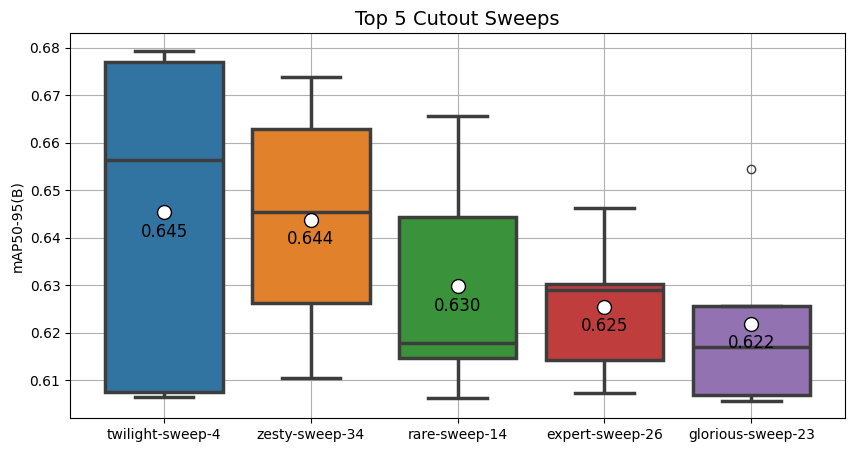

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define custom colors for each sweep
palette = sns.color_palette("tab10", n_colors=5)  # Unique colors for each sweep

# Create figure
plt.figure(figsize=(10, 5))

# Create a box plot WITHOUT showmeans
sns.boxplot(
    data=cutout_sweep_avg_topx, x='sweep_name', y='mAP50_95_B', hue='sweep_name',
    palette=palette, linewidth=2.5, showmeans=False, showfliers=True
)

# Calculate and manually plot the means to avoid Seaborn's issue
sweep_names = cutout_sweep_avg_topx['sweep_name'].unique()
for i, sweep in enumerate(sweep_names):
    subset = cutout_sweep_avg_topx[cutout_sweep_avg_topx['sweep_name'] == sweep]
    mean_value = np.mean(subset['mAP50_95_B'])  # Compute the mean for this sweep
    plt.scatter(i, mean_value, color='white', edgecolors='black', s=100, zorder=3)  # Custom mean marker
    # add the mean value to the plot
    plt.text(i, mean_value-0.006, f'{mean_value:.3f}', ha='center', va='bottom', fontsize=12)

# Title and labels
plt.title("Top 5 Cutout Sweeps", fontsize=14)
plt.xlabel('')
plt.ylabel('mAP50-95(B)')
plt.grid()

# Show plot
plt.show()


In [96]:
# extract the config from df based on the sweep_name from the top 1 in cutout_sweep_avg
for i in range(5):
    cutout_sweep_avg_top1 = cutout_sweep_avg.iloc[i]
    cutout_top1_config = df[df['sweep_name'] == cutout_sweep_avg_top1['sweep_name']].iloc[0]['config']
    print(f"Top {i+1} cutout sweep config: {cutout_top1_config}")

Top 1 cutout sweep config: {'lr': 0.0022475505169469697, 'imgsz': 467, 'optimizer': 'SGD', 'batch_size': 23}
Top 2 cutout sweep config: {'lr': 0.00044433383294849944, 'imgsz': 221, 'optimizer': 'Adam', 'batch_size': 28}
Top 3 cutout sweep config: {'lr': 0.009143734315692351, 'imgsz': 307, 'optimizer': 'AdamW', 'batch_size': 18}
Top 4 cutout sweep config: {'lr': 0.004467833589627112, 'imgsz': 249, 'optimizer': 'SGD', 'batch_size': 31}
Top 5 cutout sweep config: {'lr': 0.00984627344273162, 'imgsz': 205, 'optimizer': 'Adam', 'batch_size': 19}


## WHOLE

In [97]:
# create a new dataframe that for each sweep_name has the average of the metrics across the 5 folds together with a std
whole_sweep_avg = whole_sweep.groupby('sweep_name').agg(
    # mAP50_B_avg=('metrics/mAP50(B)', 'mean'),
    # mAP50_B_std=('metrics/mAP50(B)', 'std'),
    # mAP50_B_max=('metrics/mAP50(B)', 'max'),
    # mAP50_B_min=('metrics/mAP50(B)', 'min'),
    mAP50_95_B_avg=('metrics/mAP50-95(B)', 'mean'),
    # mAP50_95_B_std=('metrics/mAP50-95(B)', 'std'),
    # mAP50_95_B_min=('metrics/mAP50-95(B)', 'min'),
    # mAP50_95_B_max=('metrics/mAP50-95(B)', 'max'),
).reset_index()

# to each row add the metric for each fold as a column
for i in range(5):
    whole_sweep_avg[f'mAP50_95_B_fold_{i}'] = whole_sweep_avg['sweep_name'].apply(
        lambda x: whole_sweep[(whole_sweep['sweep_name'] == x) & (whole_sweep['fold_number'] == str(i))]['metrics/mAP50-95(B)'].values[0]
    )

# now we sort the new dataframe by the average of the mAP50-95(B) metric in descending order
whole_sweep_avg = whole_sweep_avg.sort_values(by='mAP50_95_B_avg', ascending=False).reset_index(drop=True)
whole_sweep_avg.head()

,sweep_name,mAP50_95_B_avg,mAP50_95_B_fold_0,mAP50_95_B_fold_1,mAP50_95_B_fold_2,mAP50_95_B_fold_3,mAP50_95_B_fold_4
0,faithful-sweep-13,0.974863,0.976507,0.974468,0.975692,0.975735,0.971915
1,swift-sweep-23,0.974400,0.974088,0.974887,0.975175,0.975070,0.972779
2,warm-sweep-8,0.972774,0.976900,0.975087,0.971690,0.972915,0.967276
3,fine-sweep-10,0.968728,0.968146,0.970465,0.967479,0.971602,0.965945
4,volcanic-sweep-23,0.968231,0.969050,0.968792,0.967905,0.968260,0.967149


In [98]:
# plot top two whole_sweep_avg with sweep_name as label, and then plot each of the fold metrics as a line
# plot the average of the metrics for each sweep_name
import matplotlib.pyplot as plt
import seaborn as sns

# Extract data points for the top two sweep_names
whole_sweep_avg_topx = whole_sweep_avg.head(5)
whole_sweep_avg_topx = whole_sweep_avg_topx.melt(
    id_vars=['sweep_name', 'mAP50_95_B_avg'],
    value_vars=[f'mAP50_95_B_fold_{i}' for i in range(5)],
    var_name='fold',
    value_name='mAP50_95_B'
)

whole_sweep_avg_topx

,sweep_name,mAP50_95_B_avg,fold,mAP50_95_B
0,faithful-sweep-13,0.974863,mAP50_95_B_fold_0,0.976507
1,swift-sweep-23,0.974400,mAP50_95_B_fold_0,0.974088
2,warm-sweep-8,0.972774,mAP50_95_B_fold_0,0.976900
3,fine-sweep-10,0.968728,mAP50_95_B_fold_0,0.968146
4,volcanic-sweep-23,0.968231,mAP50_95_B_fold_0,0.969050
5,faithful-sweep-13,0.974863,mAP50_95_B_fold_1,0.974468
6,swift-sweep-23,0.974400,mAP50_95_B_fold_1,0.974887
7,warm-sweep-8,0.972774,mAP50_95_B_fold_1,0.975087
8,fine-sweep-10,0.968728,mAP50_95_B_fold_1,0.970465
9,volcanic-sweep-23,0.968231,mAP50_95_B_fold_1,0.968792


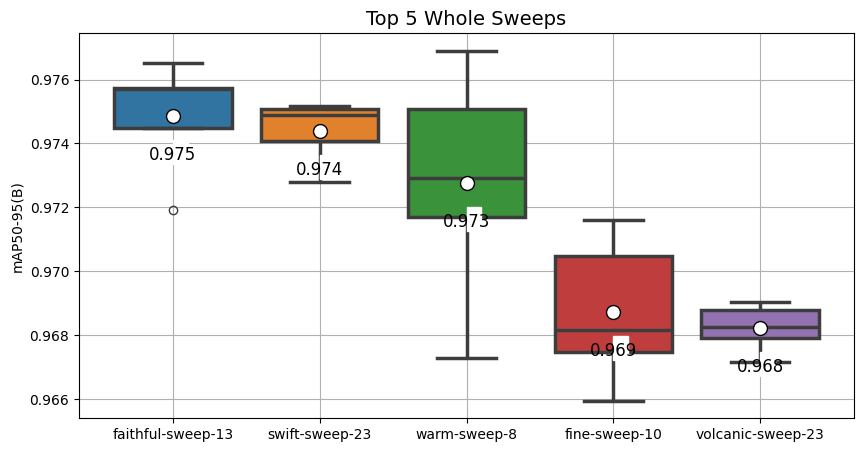

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define custom colors for each sweep
palette = sns.color_palette("tab10", n_colors=5)  # Unique colors for each sweep

# Create figure
plt.figure(figsize=(10, 5))

# Create a box plot WITHOUT showmeans
sns.boxplot(
    data=whole_sweep_avg_topx, x='sweep_name', y='mAP50_95_B', hue='sweep_name',
    palette=palette, linewidth=2.5, showmeans=False, showfliers=True
)

# Calculate and manually plot the means to avoid Seaborn's issue
sweep_names = whole_sweep_avg_topx['sweep_name'].unique()
for i, sweep in enumerate(sweep_names):
    subset = whole_sweep_avg_topx[whole_sweep_avg_topx['sweep_name'] == sweep]
    mean_value = np.mean(subset['mAP50_95_B'])  # Compute the mean for this sweep
    plt.scatter(i, mean_value, color='white', edgecolors='black', s=100, zorder=3)  # Custom mean marker
    # add the mean value to the plot with a background behgind the text
    plt.text(i, mean_value-0.0015, f'{mean_value:.3f}', ha='center', va='bottom', fontsize=12)
    # plot a rectangle behind the text for visibility
    plt.gca().add_patch(plt.Rectangle((i, mean_value-0.0015), 0.1, 0.00075, fill=True, color='white', zorder=2))
    
# Title and labels
plt.title("Top 5 Whole Sweeps", fontsize=14)
plt.xlabel('')
plt.ylabel('mAP50-95(B)')
plt.grid()

# Show plot
plt.show()


In [100]:
# extract the config from df based on the sweep_name from the top 1 in cutout_sweep_avg
for i in range(5):
    whole_sweep_avg_top1 = whole_sweep_avg.iloc[i]
    whole_top1_config = df[df['sweep_name'] == whole_sweep_avg_top1['sweep_name']].iloc[0]['config']
    print(f"Top {i+1} whole sweep config: {whole_top1_config}")

Top 1 whole sweep config: {'lr': 0.0051874277583658784, 'imgsz': 582, 'optimizer': 'AdamW', 'batch_size': 14}
Top 2 whole sweep config: {'lr': 0.008656498900333062, 'imgsz': 607, 'optimizer': 'AdamW', 'batch_size': 20}
Top 3 whole sweep config: {'lr': 0.004458700064643615, 'imgsz': 525, 'optimizer': 'AdamW', 'batch_size': 29}
Top 4 whole sweep config: {'lr': 0.002118085098390609, 'imgsz': 319, 'optimizer': 'Adam', 'batch_size': 13}
Top 5 whole sweep config: {'lr': 0.006131104826692219, 'imgsz': 225, 'optimizer': 'AdamW', 'batch_size': 18}


# Loss curves

In [341]:
# read file from csv
loss_names = ["box.csv", "cls.csv", "dfl.csv"]
dir_names = ["swift", "faithful"]
data_dir = "../../data/wandb"

In [342]:
# We wish to create a dataframe that contains 5 columns, index, dir_name, box, cls, dfl

# create a list of dataframes, each dataframe is a dir name with the loss names as columns
dfs = []
for dir_name in dir_names:
    dfs_dir = []
    for loss_name in loss_names:
        df = pd.read_csv(f'{data_dir}/{dir_name}/{loss_name}')
        df['dir_name'] = dir_name
        dfs_dir.append(df)
    dfs.append(pd.concat(dfs_dir, axis=1))

df1 = dfs[0]
df2 = dfs[1]

df1 = df1.drop(columns=['dir_name'])
df2 = df2.drop(columns=['dir_name'])

# rename step to epoch
df1.rename(columns={'Step': 'Epoch'}, inplace=True)
df2.rename(columns={'Step': 'Epoch'}, inplace=True)

new_names_df1 = []
for col in df1.columns:
    if col == 'Epoch':
        new_names_df1.append(col)
    else:
        if "MIN" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df1.append(f"{name}_MIN")
        elif "MAX" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df1.append(f"{name}_MAX")
        else:
            new_names_df1.append("".join("_".join(col.split('-')[-2:]).split(" ")))

new_names_df2 = []
for col in df2.columns:
    if col == 'Epoch':
        new_names_df2.append(col)
    else:
        if "MIN" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df2.append(f"{name}_MIN")
        elif "MAX" in col:
            name = col.split(" - ")[0].split("-")[-1] + "_" + col.split(" - ")[1].split("__")[0]
            new_names_df2.append(f"{name}_MAX")
        else:
            new_names_df2.append("".join("_".join(col.split('-')[-2:]).split(" ")))

# rename the columns
df1.columns = new_names_df1
df2.columns = new_names_df2

In [343]:
df1 = df1.loc[:, ~df1.columns.duplicated()]
df2 = df2.loc[:, ~df2.columns.duplicated()]

df1_melted = pd.melt(df1, id_vars=['Epoch'], value_vars=df1.columns[1:], var_name='variable', value_name='value')
df2_melted = pd.melt(df2, id_vars=['Epoch'], value_vars=df2.columns[1:], var_name='variable', value_name='value')

In [344]:
# extract fold and loss type from the variable column
df1_melted['fold'] = df1_melted['variable'].apply(lambda x: x.split("_")[0])
df1_melted['loss_type'] = df1_melted['variable'].apply(lambda x: x.split("_")[1] if "MIN" not in x and "MAX" not in x else x.split("_")[1])
df1_melted['min_max'] = df1_melted['variable'].apply(lambda x: x.split("_")[-1] if "MIN" in x or "MAX" in x else None)


df1_dataframes = []
# split the dataframe into 3 dataframes, one for each loss type
for loss_type in df1_melted['loss_type'].unique():
    df1_loss_type = df1_melted[df1_melted['loss_type'] == loss_type]
    df1_dataframes.append(df1_loss_type)

df1_mean_dataframes = []
# for each dataframe, group by epoch and calculate the mean and save the loss type
for df1_loss_type in df1_dataframes:
    df1_mean = df1_loss_type.groupby('Epoch').agg(
        value_mean=('value', 'mean'),
        max_mean=('value', 'max'),
        min_mean=('value', 'min')
    ).reset_index()
    df1_mean['loss_type'] = df1_loss_type['loss_type'].iloc[0]
    df1_mean_dataframes.append(df1_mean)


df2_melted['fold'] = df2_melted['variable'].apply(lambda x: x.split("_")[0])
df2_melted['loss_type'] = df2_melted['variable'].apply(lambda x: x.split("_")[1] if "MIN" not in x and "MAX" not in x else x.split("_")[1])
df2_melted['min_max'] = df2_melted['variable'].apply(lambda x: x.split("_")[-1] if "MIN" in x or "MAX" in x else None)

df2_dataframes = []
# split the dataframe into 3 dataframes, one for each loss type
for loss_type in df2_melted['loss_type'].unique():
    df2_loss_type = df2_melted[df2_melted['loss_type'] == loss_type]
    df2_dataframes.append(df2_loss_type)

df2_mean_dataframes = []
# for each dataframe, group by epoch and calculate the mean and save the loss type
for df2_loss_type in df2_dataframes:
    df2_mean = df2_loss_type.groupby('Epoch').agg(
        value_mean=('value', 'mean'),
        max_mean=('value', 'max'),
        min_mean=('value', 'min')
    ).reset_index()
    df2_mean['loss_type'] = df2_loss_type['loss_type'].iloc[0]
    df2_mean_dataframes.append(df2_mean)

data_frames = [df1_mean_dataframes, df2_mean_dataframes]


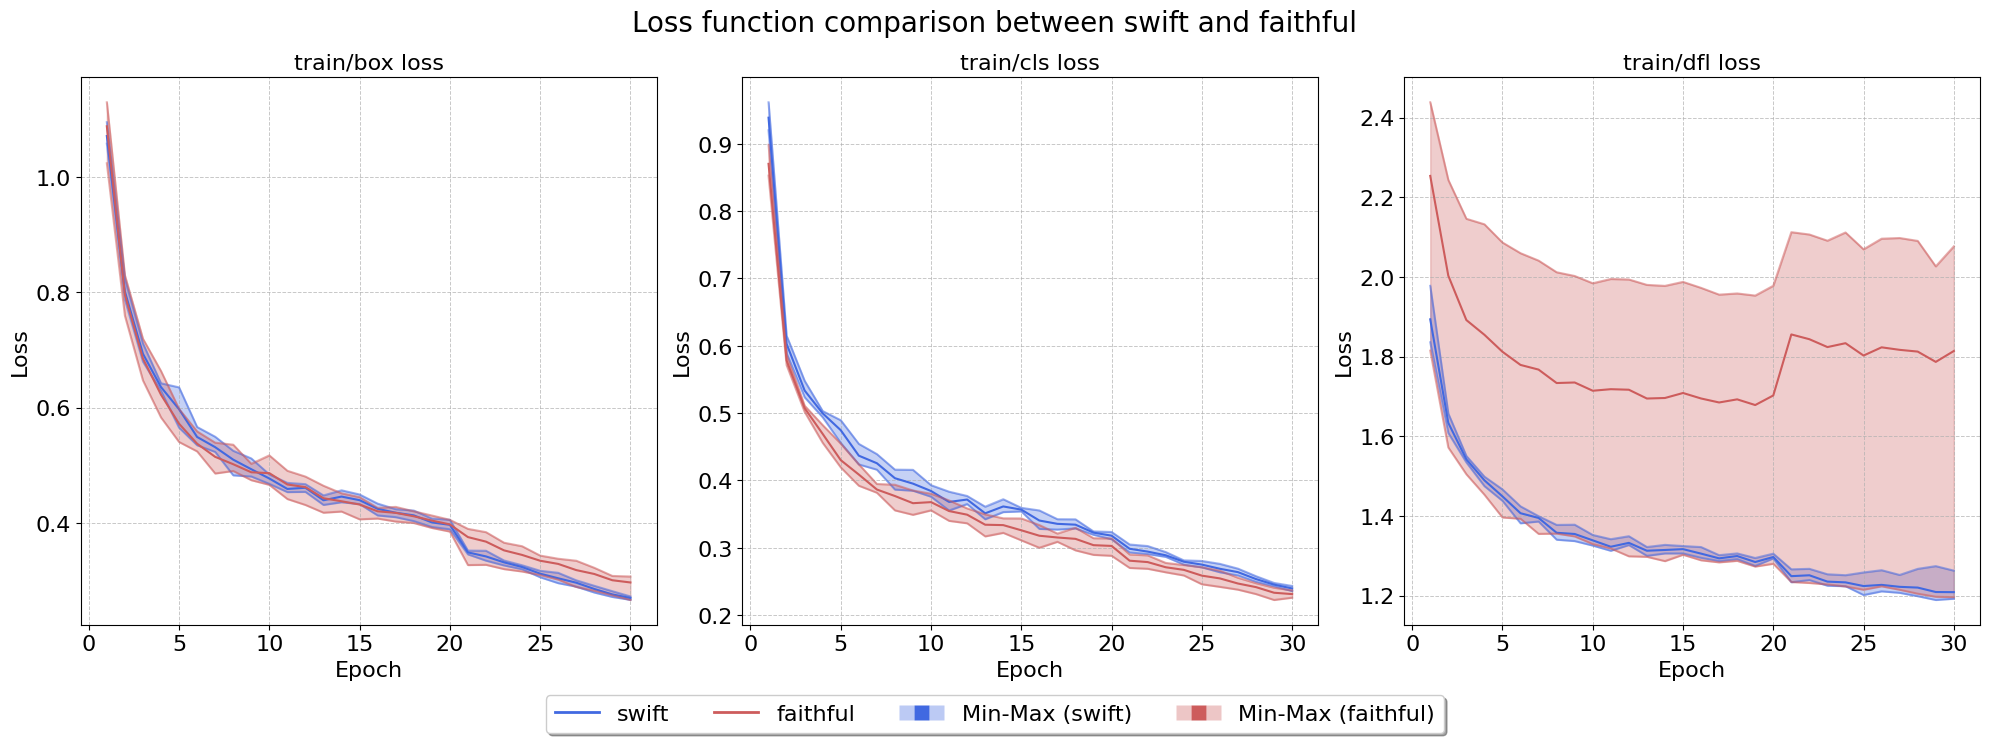

In [354]:
fig, ax = plt.subplots(1, 3, figsize=(20, 7))  # Create subplots for 3 losses
fig.suptitle(f"Loss function comparison between {dir_names[0]} and {dir_names[1]}", fontsize=20)

for j, df_list in enumerate(data_frames):
    c = 'royalblue' if j == 0 else 'indianred'

    for i, df in enumerate(df_list):
        sns.lineplot(data=df, x='Epoch', y='value_mean', label=l1, color=c, ax=ax[i])
        sns.lineplot(data=df, x='Epoch', y='max_mean', label='Max Loss', color=c, alpha=0.5, ax=ax[i])
        sns.lineplot(data=df, x='Epoch', y='min_mean', label='Min Loss', color=c, alpha=0.5, ax=ax[i])

        # Fill area between max_mean and min_mean
        ax[i].fill_between(df['Epoch'], df['max_mean'], df['min_mean'], color=c, alpha=0.3)

        ax[i].set_title(f"{df['loss_type'].iloc[0]} loss", fontsize=16)
        ax[i].set_xlabel('Epoch', fontsize=16)
        ax[i].set_ylabel('Loss', fontsize=16)
        
        # ticks
        ax[i].tick_params(axis='both', which='major', labelsize=16)
        # Hide legend
        ax[i].get_legend().remove()
        
        # Ensure grid is applied AFTER Seaborn plotting
        ax[i].grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  

# Add custom legends at the bottom of the figure outside of the plot
legends = []
legends.append((mlines.Line2D([], [], color='royalblue', linestyle='-', linewidth=2, label=f'{dir_names[0]}'), f'{dir_names[0]}'))
legends.append((mlines.Line2D([], [], color='indianred', linestyle='-', linewidth=2, label=f'{dir_names[1]}'), f'{dir_names[1]}'))
legends.append((MulticolorPatch(['royalblue', 'royalblue', 'royalblue'], [0.35, 1, 0.35]), f'Min-Max ({dir_names[0]})'))
legends.append((MulticolorPatch(['indianred', 'indianred', 'indianred'], [0.35, 1, 0.35]), f'Min-Max ({dir_names[1]})'))
handles, labels = zip(*legends)
fig.legend(handles, labels, handler_map={MulticolorPatch: MulticolorPatchHandler()}, loc='lower center', 
                            bbox_to_anchor=(0.5, -0.07), fancybox=True, shadow=True, ncol=4, fontsize=16)
                            
plt.tight_layout()
plt.show()

In [ ]:
# now we plot 3 figures for each loss type, including the values for each fold in the same plot
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom colors for each fold
palette = sns.color_palette("tab10", n_colors=5)  # Unique colors for each fold

# Create figure
plt.figure(figsize=(10, 5))

